# Create occupation-level plots for ILO Scenario
Felix Zaussinger | 20.08.2021

## Core Analysis Goal(s)
1. Create stacked barplots similar to ILO 2019, page 132
2.
3.

## Key Insight(s)
1.
2.
3.

In [1]:
import os
import sys
import logging
from pathlib import Path

import numpy as np
import scipy as sp
import statsmodels.api as sm
from statsmodels.formula.api import ols

%load_ext autoreload
%autoreload 2

import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import seaborn as sns
sns.set_context("paper")
sns.set(rc={'figure.figsize': (16, 9.)})
sns.set_style("ticks")

import pandas as pd
pd.set_option("display.max_rows", 120)
pd.set_option("display.max_columns", 120)

logging.basicConfig(level=logging.INFO, stream=sys.stdout)

Define directory structure

In [2]:
# project directory
abspath = os.path.abspath('')
project_dir = str(Path(abspath).parents[0])

# sub-directories
data_raw = os.path.join(project_dir, "data", "raw")
data_interim = os.path.join(project_dir, "data", "interim")
data_processed = os.path.join(project_dir, "data", "processed")
figure_dir = os.path.join(project_dir, "reports", "figures")

Code ...

In [3]:
fpath = os.path.join(data_raw, "ilo_scenarios", "ilo_empl_scenarios_2030.xlsx")

dict_of_dfs = pd.read_excel(
    fpath,
    sheet_name=["energy_sustainability", "circular_economy"]
)

In [4]:
# rename dicts
title_dict = {
    "energy_sustainability": "Energy Sustainability Scenario",
    "circular_economy": "Circular Economy Scenario"
}

col_names = {
    "new_jobs_net": "New jobs",
    "new_jobs_absorbing": "New jobs absorbing laid-off workers",
    "jobs_lost_reallocated": "Jobs destroyed, reallocatable",
    "jobs_lost_net": "Jobs destroyed, not reallocatable"
}

#### Create stacked barplots similar to ILO 2019, page 132

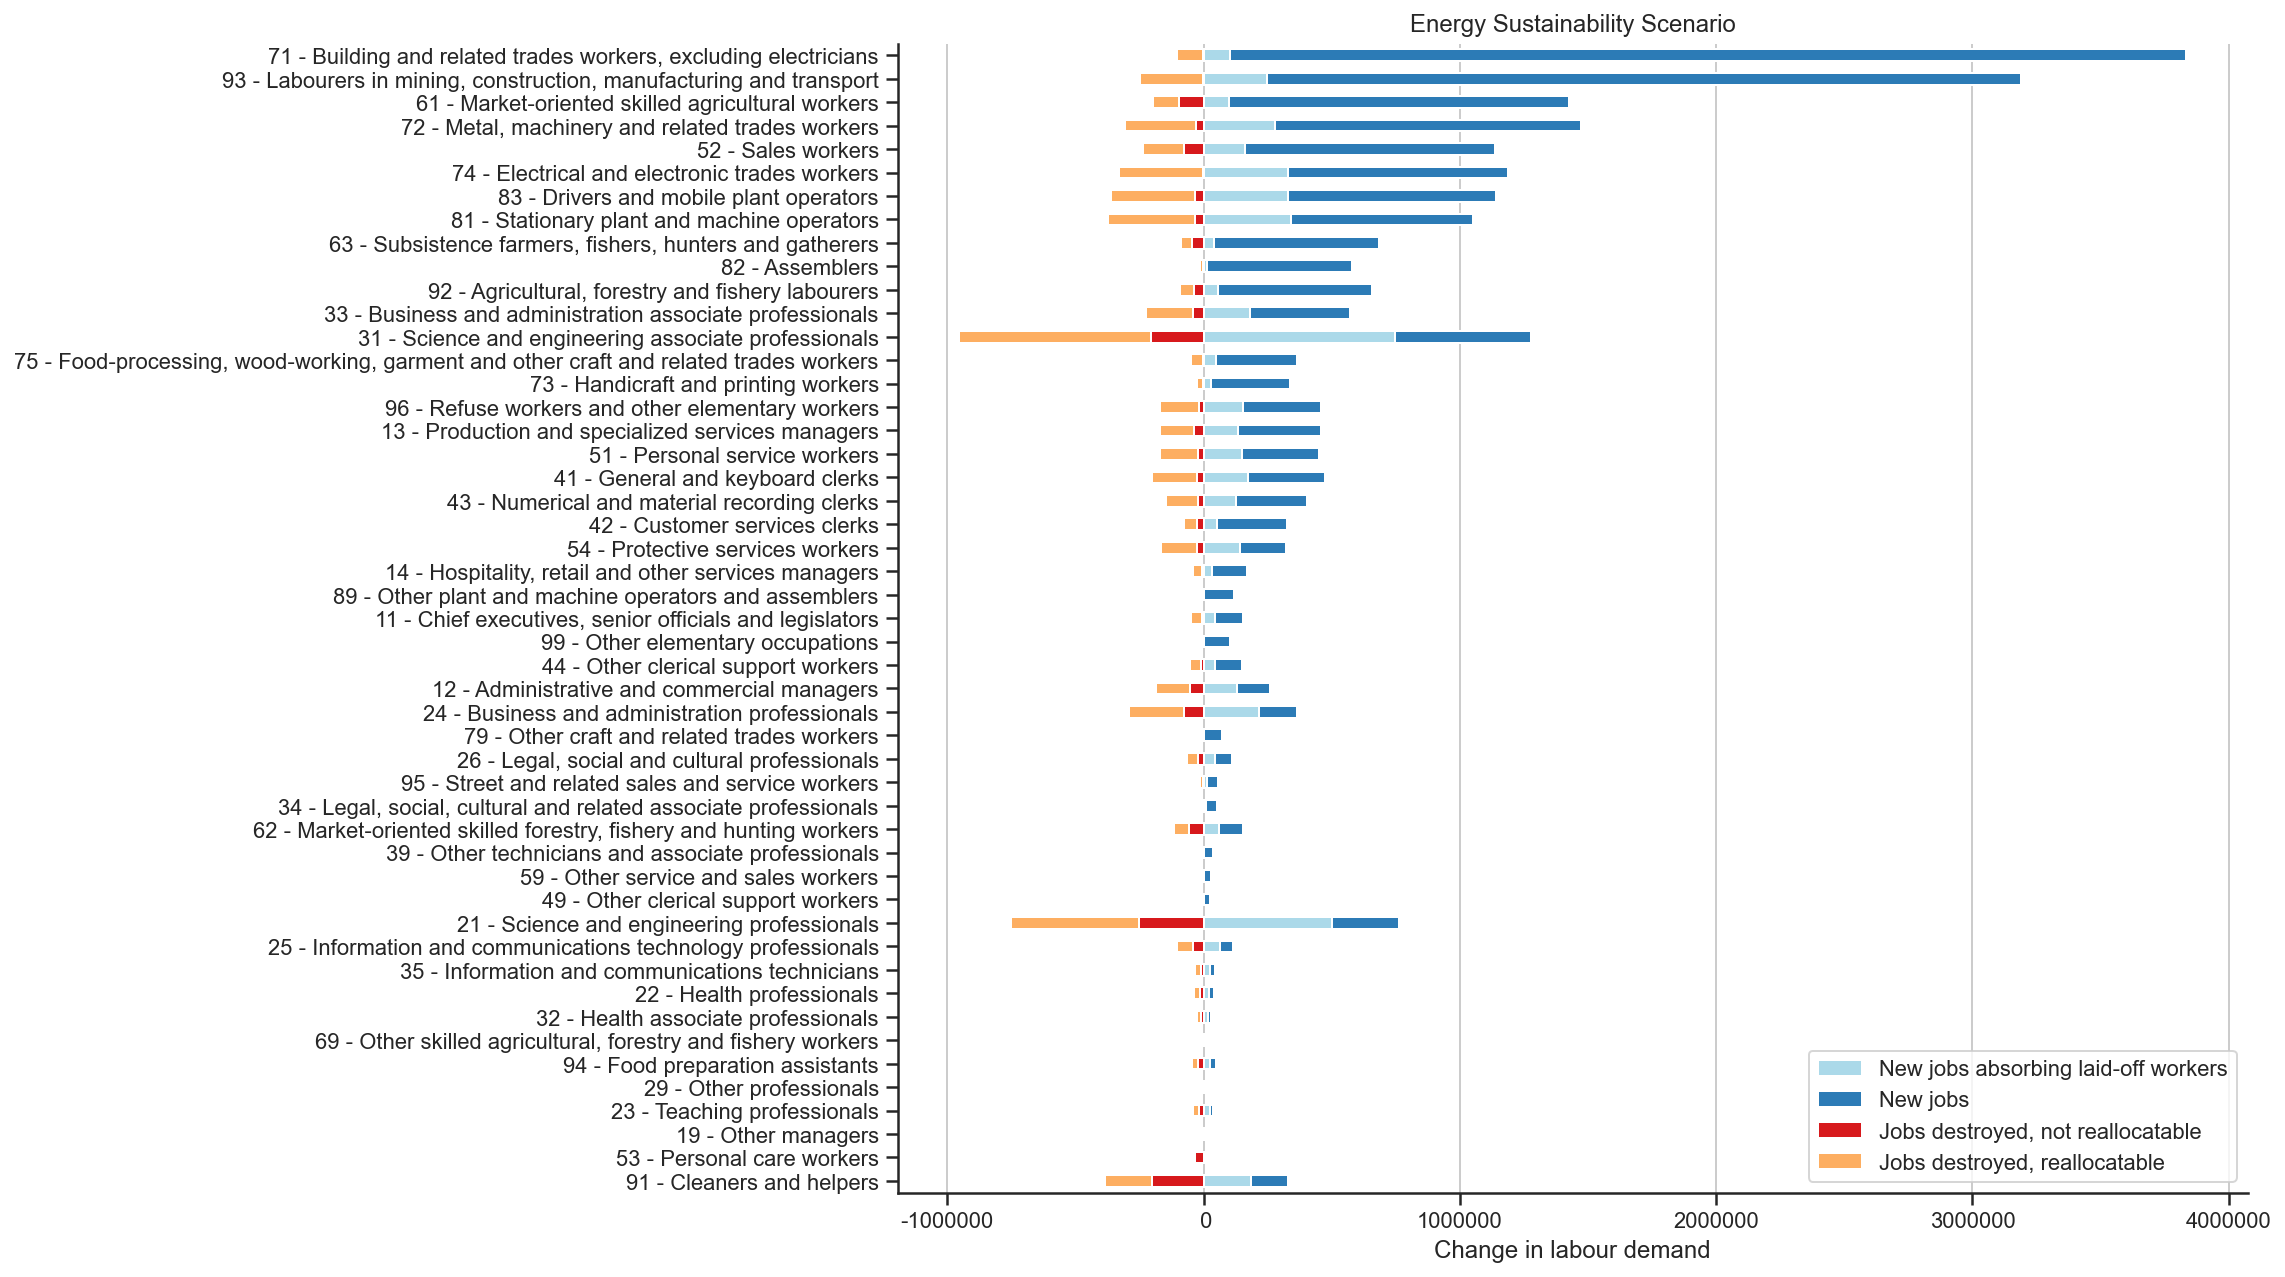

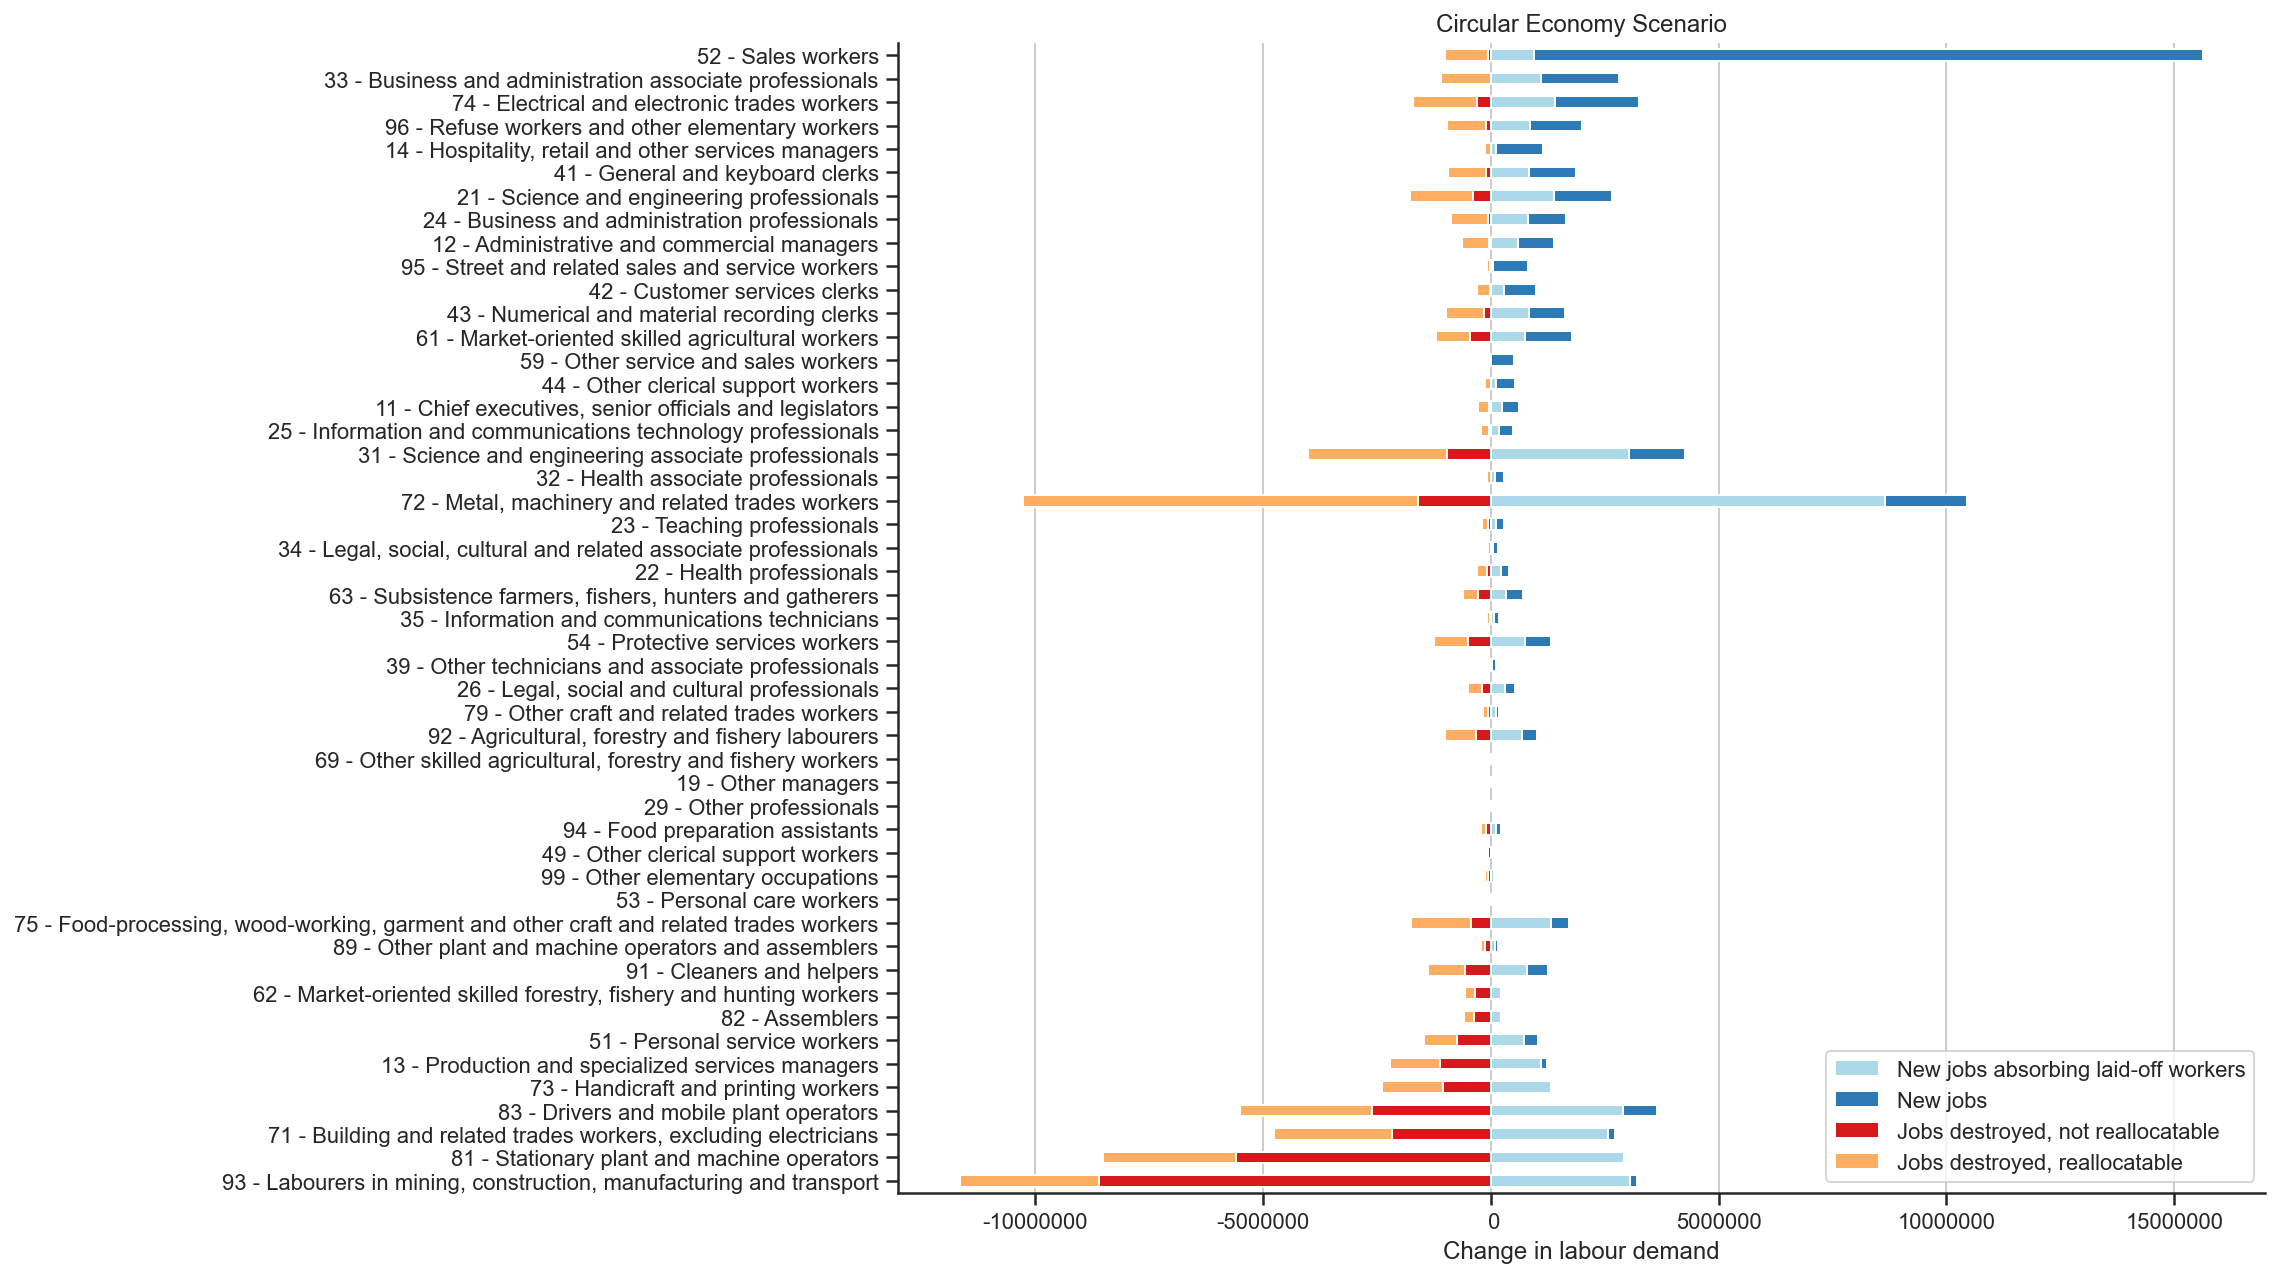

In [5]:
# ILO ES 2030
for scenario, df in dict_of_dfs.items():

    df["label"] = df["isco_code"].astype(str) + " - " + df["isco_occupation"]
    df = df.set_index("label")
    df = df.sort_values("net_change", ascending=True)
    df = df.drop(columns=["net_change", "isco_code", "isco_occupation", "skill_level"])
    df = df.rename(columns=col_names)

    # scale to millions
    df *= 1000

    # plot
    colors = {
        "New jobs": "#2c7bb6",
        "New jobs absorbing laid-off workers": "#abd9e9",
        "Jobs destroyed, reallocatable": "#fdae61",
        "Jobs destroyed, not reallocatable": "#d7191c"
    }

    ax = df.plot.barh(stacked=True, color=colors)
    ax.set_xlabel("Change in labour demand")
    ax.set_ylabel(None)
    ax.set_title(title_dict[scenario])
    ax.grid(axis='x')

    ax.xaxis.set_major_formatter(plt.FormatStrFormatter('%2d'))

    sns.despine()
    plt.legend(loc="lower right")
    plt.tight_layout()

    plt.savefig(
        os.path.join(figure_dir, "RQ2", "{}.png".format(scenario)),
        dpi=150,
        bbox_inches="tight"
    )

#### Skill level distribution
- for comparison with IEA skill level distribution
- % of H/M/L skilled new jobs under ILO ES, CE scenarios

In [11]:
# CE
ce = dict_of_dfs["circular_economy"]
ce["positive"] = ce.new_jobs_absorbing + ce.new_jobs_net
ce["negative"] = ce.jobs_lost_reallocated + ce.jobs_lost_net
ce["delta"] = ce["positive"] + ce["negative"]
ce_res = ce[["skill_level", "positive", "negative", "delta"]].groupby("skill_level").sum()
ce_res = ce_res.reindex(["H", "M", "L"])
ce_res *= 1000

ce_res_percent = ce_res.positive / ce_res.positive.sum()
ce_res_percent *= 100
ce_res_percent.name = "Circular Economy (ILO)"

In [12]:
# ES
es = dict_of_dfs["energy_sustainability"]
es["positive"] = es.new_jobs_absorbing + es.new_jobs_net
es["negative"] = es.jobs_lost_reallocated + es.jobs_lost_net
es["delta"] = es["positive"] + es["negative"]
es_res = es[["skill_level", "positive", "negative", "delta"]].groupby("skill_level").sum()
es_res = es_res.reindex(["H", "M", "L"])
es_res *= 1000

es_res_percent = es_res.positive / es_res.positive.sum()
es_res_percent *= 100
es_res_percent.name = "Energy Sustainability (ILO)"

In [13]:
res = pd.concat([es_res_percent, ce_res_percent], axis=1).T
res = res.rename(columns={"H": "High", "M": "Medium", "L": "Low"})

#### Add IEA Net Zero 2050 data

In [27]:
iea = pd.DataFrame({"High": 65, "Medium": 27, "Low": 8},
                   index=["Net Zero (IEA)"])

res_all = pd.concat([res, iea])

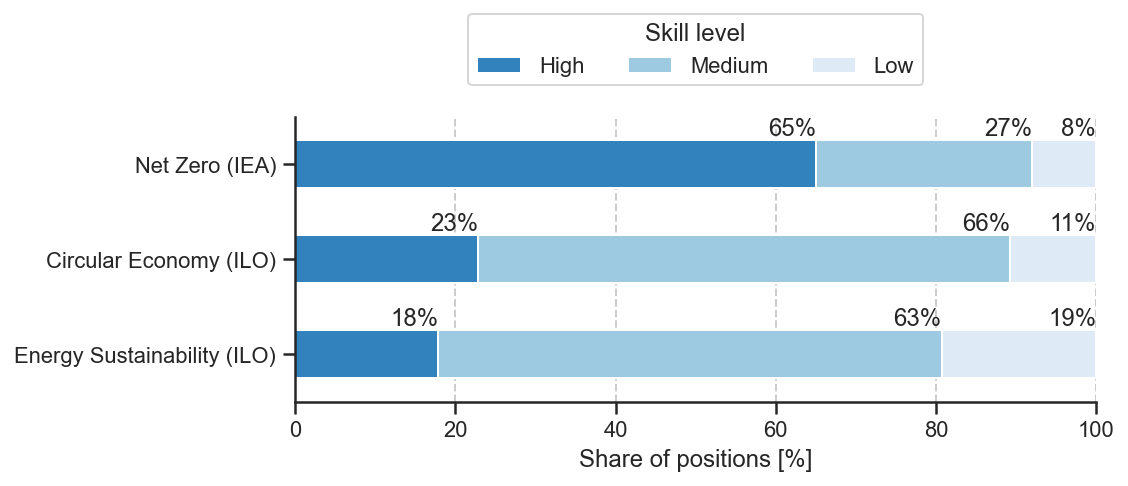

In [59]:
sns.set_style("ticks", {'axes.grid': True, "grid.linestyle": "--"})

colors = ["#3182bd", "#9ecae1", "#deebf7"]
ax = res_all.plot.barh(stacked=True, color=colors, figsize=(8, 3))

for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy()
    ax.text(x+width,
            y+height,
            '{:.0f}%'.format(width),
            horizontalalignment='right',
            verticalalignment='bottom')

# Shrink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width, box.height * 0.8])
#ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), title="Skill level")

ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.4),
          ncol=3, title="Skill level")

ax.set_xlabel("Share of positions [%]")
ax.set_xlim(0, 100)

sns.despine()
plt.tight_layout()

plt.savefig(
        os.path.join(figure_dir, "RQ2", "skill_level_comparison.png"),
        dpi=300,
        bbox_inches="tight"
    )